# Custering of a Quantum Convolutional Processed Dataset

This notebook contains all the rutines to apply clustering methods to a quantum convolution processed dataset. The script will:

1. Load the dataset and print some statistics
2. Apply a clustering method
3. Showt the results

In [1]:
from data.datahandler import datahandler
from data.datareader import datareader
from layers.QConv2D import QConv2D
from utils import test_loader
from utils.plotter import *

from sklearn.cluster import Birch, KMeans, SpectralClustering, DBSCAN
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpy import unique
from numpy import where
import numpy as np
import os

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

SEED = 10
from numpy import random
random.seed(SEED)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/asebastianelli/miniforge3/envs/jax/lib/python3.10/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/asebastianelli/miniforge3/envs/jax/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Load dataset

Instructions
1. the dataset should be placed in the working directory, specifically in the **datasets** folder.
2. the dataset should be already divided into classes, one-subfolder for earch classes. The folder/class name will be used to encode the label

```
QuantumCNN
│   README.md
│   requirements.txt    
│
└───circuits
└───...
└───datasets
    └───EuroSAT
        └───Highway
                highway1.jpg
                highway2.jpg                
        └─── ....
        └───Lake
                lake1.jpg
                lake2.jpg                

```

Given *the dataset_name*, that must be the same of the folder, the **datahandler** will take care of loading the paths of the images and collected them into a class dictionary. After a report of the dataset will be printed.

In [2]:
dataset_name = 'EuroSAT_processed_QCNN_1'
root = os.path.join('datasets', dataset_name)
dhandler = datahandler(root)
dhandler.print_report(name=dataset_name)


Dataset EuroSAT_processed_QCNN_1

Class 0 - Forest                    - #images: 3000
Class 1 - River                     - #images: 2500
Class 2 - Highway                   - #images: 2500
Class 3 - AnnualCrop                - #images: 3000
Class 4 - SeaLake                   - #images: 3000
Class 5 - HerbaceousVegetation      - #images: 3000
Class 6 - Industrial                - #images: 2500
Class 7 - Residential               - #images: 3000
Class 8 - PermanentCrop             - #images: 2500
Class 9 - Pasture                   - #images: 2000


The **unpack** function trasforms the dataset from a dictionary to an array. It assigns also the label to each image and returns a dictionary mapping the labels with the class name

In [36]:
labels_mapper, x, y = dhandler.unpack(dhandler.paths)

print('Labels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x)))

print('\nTraining Dataset samples')
print('{:<30s}{:<80s}{:<10s}{}'.format('X Train', x[0], 'Size', np.load(x[0]).shape))
print('{:<30s}{}'.format('X Train', y[0]))
classes = list(labels_mapper.keys())

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway                       [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
AnnualCrop                    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
SeaLake                       [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
HerbaceousVegetation          [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Industrial                    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Residential                   [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
PermanentCrop                 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Pasture                       [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Dataset Size
Images                        27000

Training Dataset samples
X Train                       datasets/EuroSAT_processed_QCNN_1/Forest/Forest_576.npy                         Size      (3, 3, 12)
X Train                       [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Test the keras-like data loader. In this specific case the *datareader.generatorv2* is tested. It contains all the rutines to load images batch by batch (1 in this case).

In [37]:
def reshape(x):
    for i in range(x.shape[-1]):
        if i == 0:
            vals = x[:,:,i].flatten()
        else:
            vals = np.concatenate((vals, x[:,:,i].flatten()))
    return vals

In [38]:
loader  = iter(datareader.generatorv2((x, y), (3,3,12)))
X = []
Y = []

for _ in tqdm(range(len(x))):    
    it = next(loader)
    lbl = np.argmax(it[1])
    #if lbl == 0 or lbl == 1:
    X.append(reshape(it[0]))
    Y.append(lbl)

Y = np.array(Y)
X = np.array(X)

  0%|          | 0/27000 [00:00<?, ?it/s]

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=10, random_state=SEED)#, svd_solver='full')
X_std = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)

[0.29618874 0.067007   0.06227834 0.06162145 0.03699009 0.034106
 0.03044137 0.02813536 0.02328396 0.02267668]


In [40]:
N_CLUSTERS = 10

In [41]:
errors, threshold, branching_factor = [], [], []
best_err, best_th, best_br = 1000, 0, 0

for t in np.flip(np.arange(0.01, 1.01, 0.01)):
    for b in range(2, 100, 1):
        km = Birch(threshold=t, #0.86, #1, 
                    branching_factor=b, #9,#5,
                    n_clusters=N_CLUSTERS,
                    compute_labels=True,
                    copy=True)

        yhat = km.fit_predict(X_std)
        yhatct = -np.sort(-np.bincount(yhat))
        yct = -np.sort(-np.bincount(Y))
        err = np.sum(np.abs(yct - yhatct))/ np.sum(yct)   
        
        if err <= best_err:
            best_err=err
            best_th=t
            best_br=b
        
        print('\r Current Error {:.5f} - Threshold {:.2f} - Branching Factor {} -- Best Error {:.5f} - Threshold {:.2f} - Branching Factor {} '.format(err,t,b,best_err, best_th, best_br), end='\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t')
        errors.append(err)
        threshold.append(t)
        branching_factor.append(b)

M = np.argmin(errors)
print('Min {} - Error - {:.5f} - Threshold {:.2f} - Branching Factor {}'.format(M, errors[M], threshold[M], branching_factor[M]))

 Current Error 0.1945925925925926 - Threshold 0.01 - Branching Factor 99 -- Best Errorr 0.10888888888888888 - Threshold 0.5700000000000001 - Branching Factor 42 																Min 4254 - Error - 0.10888888888888888 - Threshold 0.5700000000000001 - Branching Factor 42


Min 4254 - Error - 0.10889 - Threshold 0.57 - Branching Factor 42
Recomputed Error 0.10889


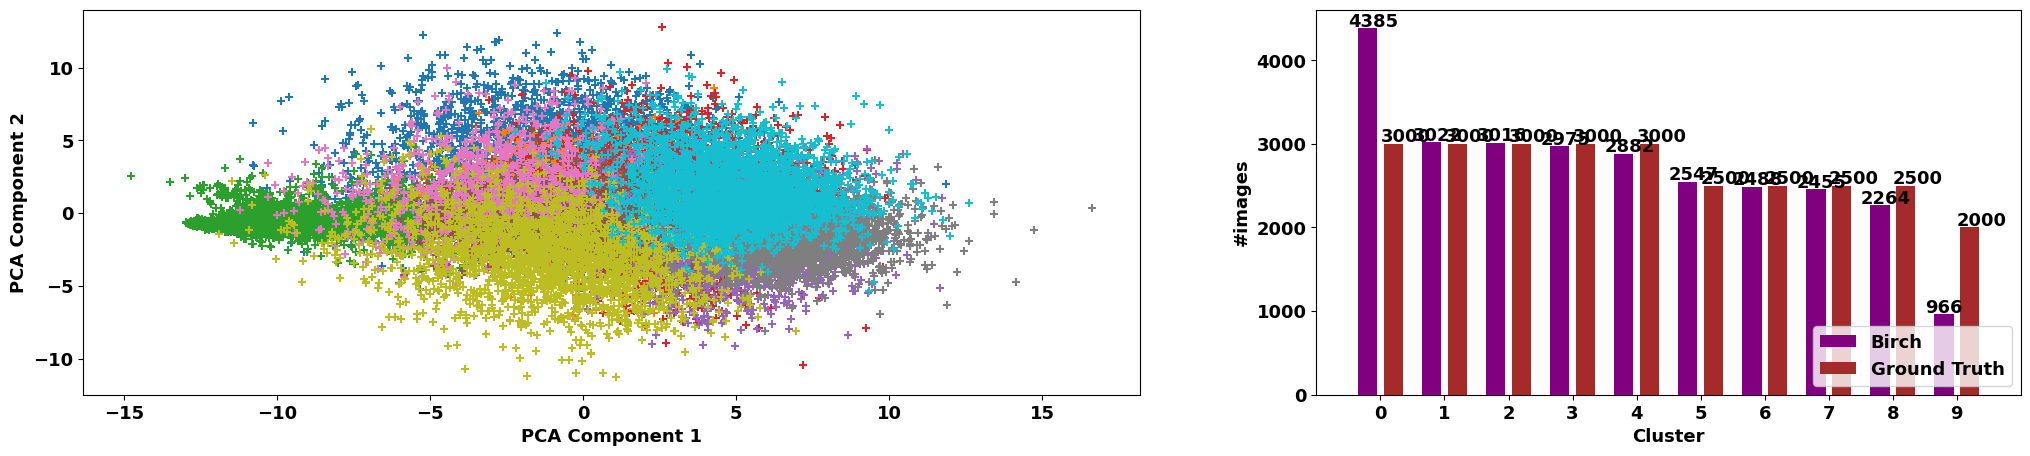

In [47]:
M = np.argmin(errors)
print('Min {} - Error - {:.5f} - Threshold {:.2f} - Branching Factor {}'.format(M, errors[M], threshold[M], branching_factor[M]))
km = Birch(threshold=threshold[M], #0.86, #1, 
                    branching_factor=branching_factor[M], #9,#5,
                    n_clusters=N_CLUSTERS,
                    compute_labels=True,
                    copy=True)

yhat = km.fit_predict(X_std)
yhatct = -np.sort(-np.bincount(yhat))
yct = -np.sort(-np.bincount(Y))
err = np.sum(np.abs(yct - yhatct))/ np.sum(yct)
print('Recomputed Error {:.5f}'.format(err))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 5), gridspec_kw={'width_ratios': [3, 2]})
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for i, cluster in enumerate(clusters):
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    ax[0].scatter(X_std[row_ix, 0], X_std[row_ix, 1], marker='+')
    ax[0].set_xlabel('PCA Component 1')
    ax[0].set_ylabel('PCA Component 2')

xx = np.arange(N_CLUSTERS) - 0.2
ax[1].bar(xx,  yhatct, width=0.3, align='center', label='Birch', color='purple')

for i, val in enumerate(yhatct):
    ax[1].text(i-0.5, 20+val, val)

xx = np.arange(N_CLUSTERS) + 0.2
ax[1].bar(xx,  yct, width=0.3, align='center', label='Ground Truth', color='brown')
for i, val in enumerate(yct):
    ax[1].text(i,   20+val, val)

ax[1].set(xticks=range(N_CLUSTERS), xlim=[-1, N_CLUSTERS])    
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('#images')
mm = np.bincount(Y).max()
#ax[1].set_ylim([None,mm+(20*mm)/100])
ax[1].legend(loc='lower right')

plt.show()
plt.close()